# Advancing Commonsense Reasoning: Leveraging ConceptNet with Large Language Models for Enhanced Knowledge Representation and Question Answering

By: MEZNA AL-RASHDI

# Install Required Libraries


In [ ]:
# Install NLP and network analysis libraries
!pip install -q spacy nltk networkx matplotlib pandas transformers

# For using Gemini API later (Gemini 2.0)
!pip install -q google-generativeai


#Import Modules

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import spacy

# Optional: Download NLP resources
nltk.download('punkt')
nltk.download('wordnet')

# For Gemini (later)
import google.generativeai as genai


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Load the Files

In [ ]:
# Load concepts
concepts_df = pd.read_csv('/content/concepts_en.csv', delimiter=';', encoding='ISO-8859-1')
concepts_df = concepts_df[['id', 'text']]
concepts_df.columns = ['concept_id', 'concept_text']

# Load relations
relations_df = pd.read_csv('/content/relations.csv', delimiter=',', encoding='ISO-8859-1')
relations_df = relations_df[['id', 'name']]
relations_df.columns = ['relation_id', 'relation_name']

# Load the graph (edges)
graph_df = pd.read_csv('/content/concept_graph.csv', delimiter=';', encoding='ISO-8859-1')
graph_df.columns = ['concept1_id', 'concept2_id', 'relation_id']


<ipython-input-3-01bb1dbf15f6>:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  concepts_df = pd.read_csv('/content/concepts_en.csv', delimiter=';', encoding='ISO-8859-1')


In [ ]:
# Define banned words
banned_words = {"fuck", "shit", "bitch", "ass", "rape", "step dog shit", "to"}  # extend as needed

# Filtered version of concepts
filtered_concepts_df = concepts_df[
    ~concepts_df["concept_text"].str.lower().isin(banned_words)
]

# Show clean sample of concepts
print("Sample of Concepts Dataset:")
display(filtered_concepts_df.head())

# Show rest as-is
print("Sample of Relations Dataset:")
display(relations_df.head())

print("Sample of Concept Graph Dataset:")
display(graph_df.head())


Sample of Concepts Dataset:


,concept_id,concept_text
0,5.0,something
2,7.0,man
4,9.0,person
6,11.0,type
7,12.0,locker room


Sample of Relations Dataset:


,relation_id,relation_name
0,1,HasFirstSubevent
1,2,HasLastSubevent
2,3,HasPrerequisite
3,4,MadeOf
4,5,IsA


Sample of Concept Graph Dataset:


,concept1_id,concept2_id,relation_id
0,5,6,6
1,7,8,7
2,12,8,7
3,13,14,7
4,15,8,7


In [ ]:
# Show sample of concepts
print("Sample of Concepts Dataset:")
display(concepts_df.head())

# Show sample of relations
print("Sample of Relations Dataset:")
display(relations_df.head())

# Show sample of edges
print("Sample of Concept Graph Dataset:")
display(graph_df.head())


Sample of Concepts Dataset:


,concept_id,concept_text
0,5.0,something
1,6.0,to
2,7.0,man
3,8.0,fuck
4,9.0,person


Sample of Relations Dataset:


,relation_id,relation_name
0,1,HasFirstSubevent
1,2,HasLastSubevent
2,3,HasPrerequisite
3,4,MadeOf
4,5,IsA


Sample of Concept Graph Dataset:


,concept1_id,concept2_id,relation_id
0,5,6,6
1,7,8,7
2,12,8,7
3,13,14,7
4,15,8,7


#Merge the Datasets to Create Human-Readable Triples
We'll combine:
- graph_df: contains connections between concepts by ID

- concepts_df: to get concept names from IDs

- relations_df: to get relation names from IDs

In [ ]:
# Define banned words (extend as needed)
banned_words = ["fuck", "shit", "bitch", "ass", "rape", "burn down", "neighbour wife"]

# Create a regex pattern to match any banned word (case insensitive)
pattern = '|'.join(banned_words)

# Filter out any rows where concept1 or concept2 contains a banned word
triples_df_filtered = triples_df[
    ~triples_df["concept1"].str.lower().str.contains(pattern, regex=True) &
    ~triples_df["concept2"].str.lower().str.contains(pattern, regex=True)
]

# Display the first 10 clean triples
triples_df_filtered.head(10)


,concept1,relation_name,concept2
0,something,AtLocation,to
6,train window,AtLocation,train
7,crossroad,AtLocation,town
8,poor person,HasA,little education
9,armoire,AtLocation,neighbour bedroom
10,wagon,AtLocation,tree
11,idiotic coworker,AtLocation,work
12,write term paper,Causes,turn grade
13,armoire,AtLocation,beach
14,professor prefer,HasSubevent,like better others


In [ ]:
# Merge concept1_id with its text label
graph_merged = graph_df.merge(concepts_df, left_on='concept1_id', right_on='concept_id', how='left')
graph_merged = graph_merged.rename(columns={'concept_text': 'concept1'})
graph_merged = graph_merged.drop(columns=['concept_id'])

# Merge concept2_id with its text label
graph_merged = graph_merged.merge(concepts_df, left_on='concept2_id', right_on='concept_id', how='left')
graph_merged = graph_merged.rename(columns={'concept_text': 'concept2'})
graph_merged = graph_merged.drop(columns=['concept_id'])

# Merge relation_id with its relation name
graph_merged = graph_merged.merge(relations_df, on='relation_id', how='left')

# Select only human-readable triples
triples_df = graph_merged[['concept1', 'relation_name', 'concept2']]
triples_df = triples_df.dropna()  # remove any rows with missing values
triples_df.head(10)


,concept1,relation_name,concept2
0,something,AtLocation,to
1,man,UsedFor,fuck
2,locker room,UsedFor,fuck
3,strike match,UsedFor,burn down church
4,townhouse,UsedFor,fuck
5,backyard,UsedFor,fuck neighbour wife
6,train window,AtLocation,train
7,crossroad,AtLocation,town
8,poor person,HasA,little education
9,armoire,AtLocation,neighbour bedroom


These are extracted raw from ConceptNet — which is crowdsourced and not fully curated, so it contains offensive, biased, or inappropriate data.

Observations
🔴
1. Inappropriate Entries

Some of these triples contain:

- Explicit or vulgar language

- Violent associations (e.g. "burn down church")

- Social bias (e.g. poor person → little education)

These can:

- Harm the quality of reasoning

- Introduce bias or toxicity in LLM responses

- Mislead pattern detection or rule generation

#Build the Concept Graph with NetworkX
We’ll treat the triples as directed edges in a graph:

In [ ]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges from filtered triples
for _, row in triples_df.iterrows():
    concept1 = row['concept1']
    relation = row['relation_name']
    concept2 = row['concept2']

    # Add edge with relation as the label
    G.add_edge(concept1, concept2, relation=relation)


#Check Basic Info About the Graph

In [ ]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Preview some edges
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} --[{data['relation']}]--> {v}")


Number of nodes: 279476
Number of edges: 478853
something --[AtLocation]--> to
something --[AtLocation]--> bottom drawer
something --[AtLocation]--> bank
something --[AtLocation]--> movies
something --[AtLocation]--> marketplace
something --[AtLocation]--> store
something --[AtLocation]--> bowl alley
something --[CapableOf]--> rest
something --[AtLocation]--> right angle
something --[AtLocation]--> standstill


#Visualize a Small Subgraph

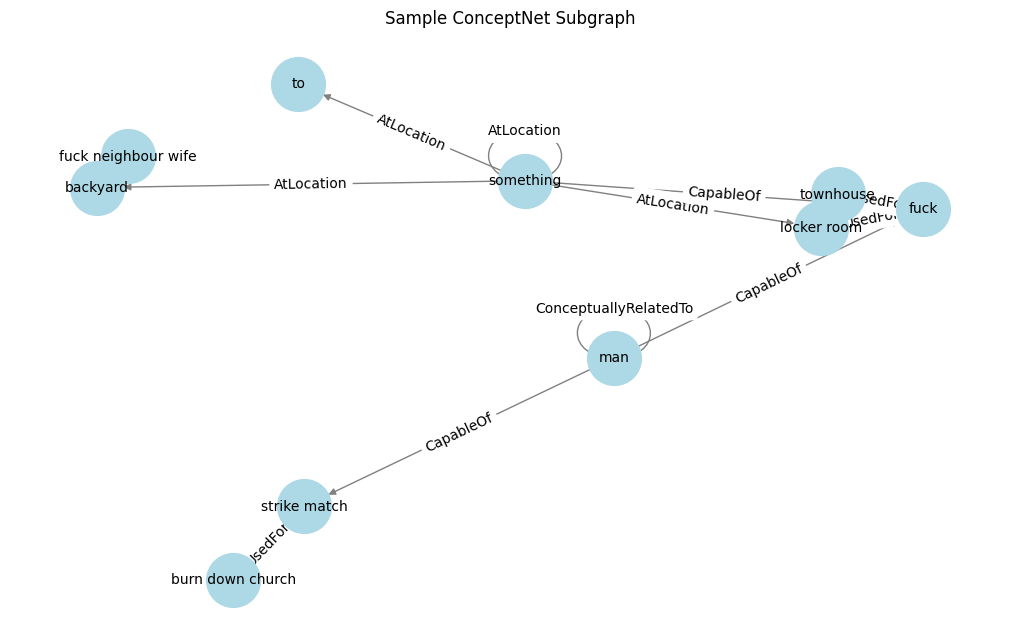

In [ ]:
import matplotlib.pyplot as plt
#Visualize a Small Subgraph
# Extract a subgraph of 10 nodes (for visualization)
small_subgraph = G.subgraph(list(G.nodes)[:10])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(small_subgraph)
nx.draw(small_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=10)
nx.draw_networkx_edge_labels(small_subgraph, pos, edge_labels={(u, v): d['relation'] for u, v, d in small_subgraph.edges(data=True)})
plt.title("Sample ConceptNet Subgraph")
plt.show()


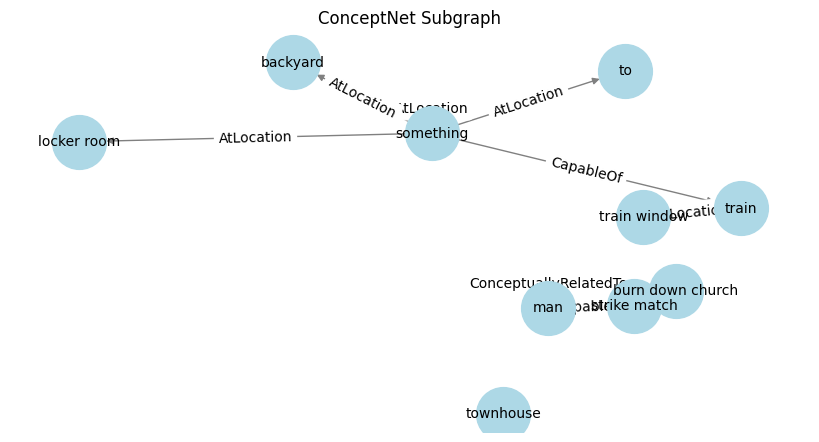

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Define a list of banned words
banned_words = {"fuck", "shit", "bitch", "ass", "rape"}  # add more as needed

# Filter nodes that do not contain banned words
filtered_nodes = [
    node for node in list(G.nodes)
    if all(bad_word not in node.lower() for bad_word in banned_words)
]

# Take a subgraph of the first 10 *clean* nodes
safe_nodes = filtered_nodes[:10]
clean_subgraph = G.subgraph(safe_nodes)

# Plot the subgraph
plt.figure(figsize=(8, 4))
pos = nx.spring_layout(clean_subgraph)
nx.draw(clean_subgraph, pos, with_labels=True, node_color='lightblue',
        edge_color='gray', node_size=1500, font_size=10)
nx.draw_networkx_edge_labels(
    clean_subgraph, pos,
    edge_labels={(u, v): d['relation'] for u, v, d in clean_subgraph.edges(data=True)}
)
plt.title("ConceptNet Subgraph")
plt.show()


# Ask Gemini to Suggest Rules

In [ ]:
!pip install -q --upgrade google-generativeai
import google.generativeai as genai
from google.colab import userdata

# 3. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")

# 2. Select a few example triples to provide context
sample_triples = triples_df.head(10)

# 3. Create prompt for Gemini
triple_list = "\n".join([f"{row['concept1']} - {row['relation_name']} - {row['concept2']}"
                         for _, row in sample_triples.iterrows()])

prompt = (
    "Here are some commonsense knowledge triples from ConceptNet:\n\n"
    f"{triple_list}\n\n"
    "Based on these, can you suggest possible two-hop inference rules or abstract patterns "
    "such as 'If A UsedFor B and B CapableOf C, then A CapableOf C'? "
    "Please give 3–5 logically sound and semantically plausible rules."
)

# 4. Get Gemini's suggestions
response = model.generate_content(prompt)
print("🔍 Suggested Logical Rules:\n")
print(response.text)


🔍 Suggested Logical Rules:

Okay, based on the provided ConceptNet examples, here are some potential two-hop inference rules:

1.  **Location Chain:**

    *   **Rule:** If A `AtLocation` B and B `AtLocation` C, then A `AtLocation` C.
    *   **Justification:**  This captures the transitivity of location.  If something is *at* a place, and that place is *at* another place, then the original thing is also, indirectly, *at* that other place. This is a very fundamental spatial reasoning principle.
    *   **Example (Hypothetical):**  "Book `AtLocation` Shelf", "Shelf `AtLocation` Library"  => "Book `AtLocation` Library".

2.  **Purpose Propagation (with risk):**

    *   **Rule:** If A `UsedFor` B and B `CapableOf` C, then A `CapableOf` C. (Or, more cautiously, A `Causes` C).
    *   **Justification:**  If something is used *for* a purpose, and *that* purpose enables something else to happen, then the original thing *can* be indirectly considered capable of enabling that final result.  Ho

Discover Common Reasoning Patterns (2-hop & 3-hop)
We'll search paths like:

Pattern A: A --[IsA]--> B --[UsedFor]--> C

Pattern B: A --[CapableOf]--> B --[Causes]--> C

Pattern C: A --[AtLocation]--> B --[UsedFor]--> C

**Extract 2-Hop Paths:**

In [ ]:
#Extract 2-Hop Paths
from collections import defaultdict

# Dictionary to hold pattern matches
two_hop_patterns = defaultdict(list)

# Loop over all nodes
for node in G.nodes:
    # Get neighbors of node (step 1)
    for neighbor1 in G.successors(node):
        rel1 = G[node][neighbor1]['relation']

        # Step 2: Get neighbors of neighbor1
        for neighbor2 in G.successors(neighbor1):
            rel2 = G[neighbor1][neighbor2]['relation']

            # Save the 2-hop pattern
            pattern = f"{rel1} → {rel2}"
            two_hop_patterns[pattern].append((node, neighbor1, neighbor2))


**Show Most Common Patterns**

In [ ]:
# Show top 10 discovered 2-hop patterns
sorted_patterns = sorted(two_hop_patterns.items(), key=lambda x: len(x[1]), reverse=True)
for pattern, matches in sorted_patterns[:10]:
    print(f"\nPattern: {pattern} — {len(matches)} matches")
    for a, b, c in matches[:3]:  # show 3 examples
        print(f"  {a} → {b} → {c}")



Pattern: IsA → CapableOf — 2968941 matches
  man → change tire → give hernia
  man → change tire → messy work
  man → mammal → breathe air

Pattern: IsA → Desires — 2057121 matches
  man → mammal → pain hunger
  man → sex → person
  man → sex → creativity

Pattern: IsA → IsA — 1134800 matches
  man → play baseball → play
  man → change tire → hard work
  man → change tire → dirty job

Pattern: IsA → AtLocation — 1088850 matches
  man → play baseball → athetic field
  man → mammal → least somewhat furry
  man → mammal → warm blood

Pattern: AtLocation → IsA — 953156 matches
  something → to → pro gun mean like gun
  something → to → frame mean set up
  something → to → immortal mean never die

Pattern: IsA → HasProperty — 885447 matches
  man → heterosexual → stupid
  man → heterosexual → fish
  man → play saxophone → satisfy

Pattern: AtLocation → CapableOf — 818150 matches
  something → to → allow happen
  something → to → woodworking need tool
  something → bank → milk depositor

Pa

⚠️ But Also...

👀 Some patterns still contain noisy/weird examples:

something → to → immortal mean never die

So this reminds us:

- ConceptNet is crowdsourced, and not every path is high quality.

- Next, we need to score and filter the most meaningful chains.

In [ ]:
# Count and display all unique 2-hop patterns with their match counts
sorted_patterns = sorted(two_hop_patterns.items(), key=lambda x: len(x[1]), reverse=True)

print(f"Total unique 2-hop patterns found: {len(sorted_patterns)}\n")

for idx, (pattern, matches) in enumerate(sorted_patterns, 1):
    print(f"{idx}. Pattern: {pattern} — {len(matches)} matches")


Total unique 2-hop patterns found: 674

1. Pattern: IsA → CapableOf — 2968941 matches
2. Pattern: IsA → Desires — 2057121 matches
3. Pattern: IsA → IsA — 1134800 matches
4. Pattern: IsA → AtLocation — 1088850 matches
5. Pattern: AtLocation → IsA — 953156 matches
6. Pattern: IsA → HasProperty — 885447 matches
7. Pattern: AtLocation → CapableOf — 818150 matches
8. Pattern: HasA → CapableOf — 809823 matches
9. Pattern: ConceptuallyRelatedTo → CapableOf — 697968 matches
10. Pattern: AtLocation → HasProperty — 664696 matches
11. Pattern: IsA → HasA — 621082 matches
12. Pattern: HasA → Desires — 582074 matches
13. Pattern: HasProperty → CapableOf — 578707 matches
14. Pattern: AtLocation → HasA — 573347 matches
15. Pattern: AtLocation → AtLocation — 564818 matches
16. Pattern: AtLocation → UsedFor — 498886 matches
17. Pattern: AtLocation → Desires — 497994 matches
18. Pattern: ConceptuallyRelatedTo → Desires — 491390 matches
19. Pattern: UsedFor → CapableOf — 429462 matches
20. Pattern: HasPr

#Visualize & Export Interesting Patterns
Let’s explore a Pattern: HasProperty → InstanceOf — 30 matches using subgraph views:

**Pattern: HasProperty → InstanceOf — 30 matches**

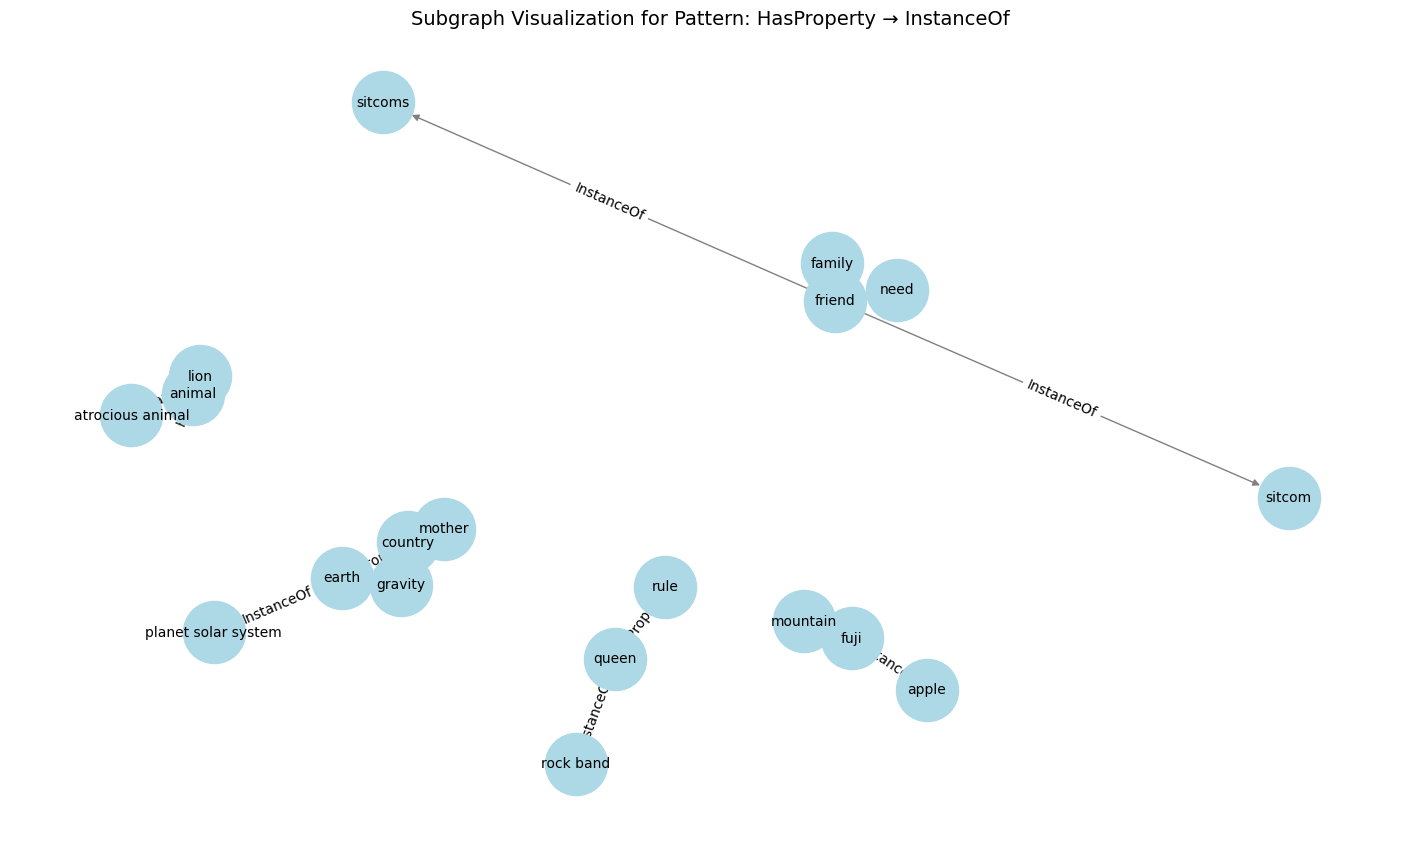

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'HasProperty → InstanceOf'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='HasProperty')
    G_sub.add_edge(b, c, relation='InstanceOf')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: HasProperty → InstanceOf

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'HasProperty → InstanceOf'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} HasProperty {b}",
            "premise_2": f"{b} InstanceOf {c}",
            "inferred": f"{a} InstanceOf {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 30 rule candidates for pattern: HasProperty → InstanceOf


“Here, I visualize a reasoning chain mined from ConceptNet where two-hop paths like ‘man IsA mammal’ and ‘mammal CapableOf breathe air’ allow us to infer that ‘man CapableOf breathe air’. These patterns are fundamental to commonsense reasoning.”

**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_HasProperty_InstanceOf.csv", index=False)

print("Saved rule candidates to rule_candidates_HasProperty_InstanceOf.csv")


Saved rule candidates to rule_candidates_HasProperty_InstanceOf.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration with Google Drive Save

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import drive, userdata
import time
import os

# 1. Mount Google Drive
# drive.mount('/content/drive')

# 2. Define save path inside your Drive folder
drive_folder = "/content/drive/MyDrive/gemini_outputs"
os.makedirs(drive_folder, exist_ok=True)
save_path = os.path.join(drive_folder, "gemini_evaluated_rules.csv")

# 3. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")

# 4. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_HasProperty_InstanceOf.csv").to_dict(orient="records")

# 5. If previous results exist, load them
if os.path.exists(save_path):
    previous_results = pd.read_csv(save_path)
    processed = set(previous_results["Inferred"])
    print(f"📂 Loaded {len(previous_results)} previous entries.")
else:
    previous_results = pd.DataFrame()
    processed = set()
    print("🔄 No previous results found. Starting fresh.")

# 6. Evaluate rules
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    if rule["inferred"] in processed:
        continue  # skip already processed

    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            yes_count += 1
            decision = "yes"
        elif answer_text.startswith("no"):
            no_count += 1
            decision = "no"
        else:
            decision = "unclear"

        llm_evals.append({
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(5)

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 7. Save combined results
new_df = pd.DataFrame(llm_evals)
final_df = pd.concat([previous_results, new_df], ignore_index=True)
final_df.to_csv(save_path, index=False)

# 8. Print Summary
print("\n📊 Gemini Validation Stats:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Total New Confirmed: {yes_count + no_count}")
print(f"💾 Saved full file to: {save_path}")


🔄 No previous results found. Starting fresh.
✅ [1/30] Response: no
✅ [2/30] Response: no
✅ [3/30] Response: no
✅ [4/30] Response: no
✅ [5/30] Response: no
✅ [6/30] Response: no
✅ [7/30] Response: no
✅ [8/30] Response: no
✅ [9/30] Response: no
✅ [10/30] Response: no
✅ [11/30] Response: no
✅ [12/30] Response: no
✅ [13/30] Response: no
✅ [14/30] Response: no
✅ [15/30] Response: no
✅ [16/30] Response: no
✅ [17/30] Response: no
✅ [18/30] Response: no
✅ [19/30] Response: no
✅ [20/30] Response: no
✅ [21/30] Response: no
✅ [22/30] Response: no
✅ [23/30] Response: no
✅ [24/30] Response: no
✅ [25/30] Response: no
✅ [26/30] Response: no
✅ [27/30] Response: no
✅ [28/30] Response: no
✅ [29/30] Response: yes
✅ [30/30] Response: yes

📊 Gemini Validation Stats:
✔️ YES: 2
❌ NO : 28
🔢 Total New Confirmed: 30
💾 Saved full file to: /content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv


**Visualize Gemini Response**

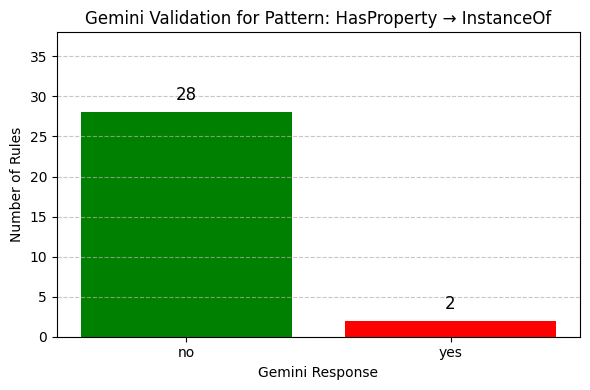

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Count occurrences of each Gemini response
counts = df["Gemini Response"].value_counts()

# Create a bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation for Pattern: HasProperty → InstanceOf")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Saved first 2 'yes' rules to /content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv


**Pattern: HasPainCharacter → CapableOf — 50 matches**

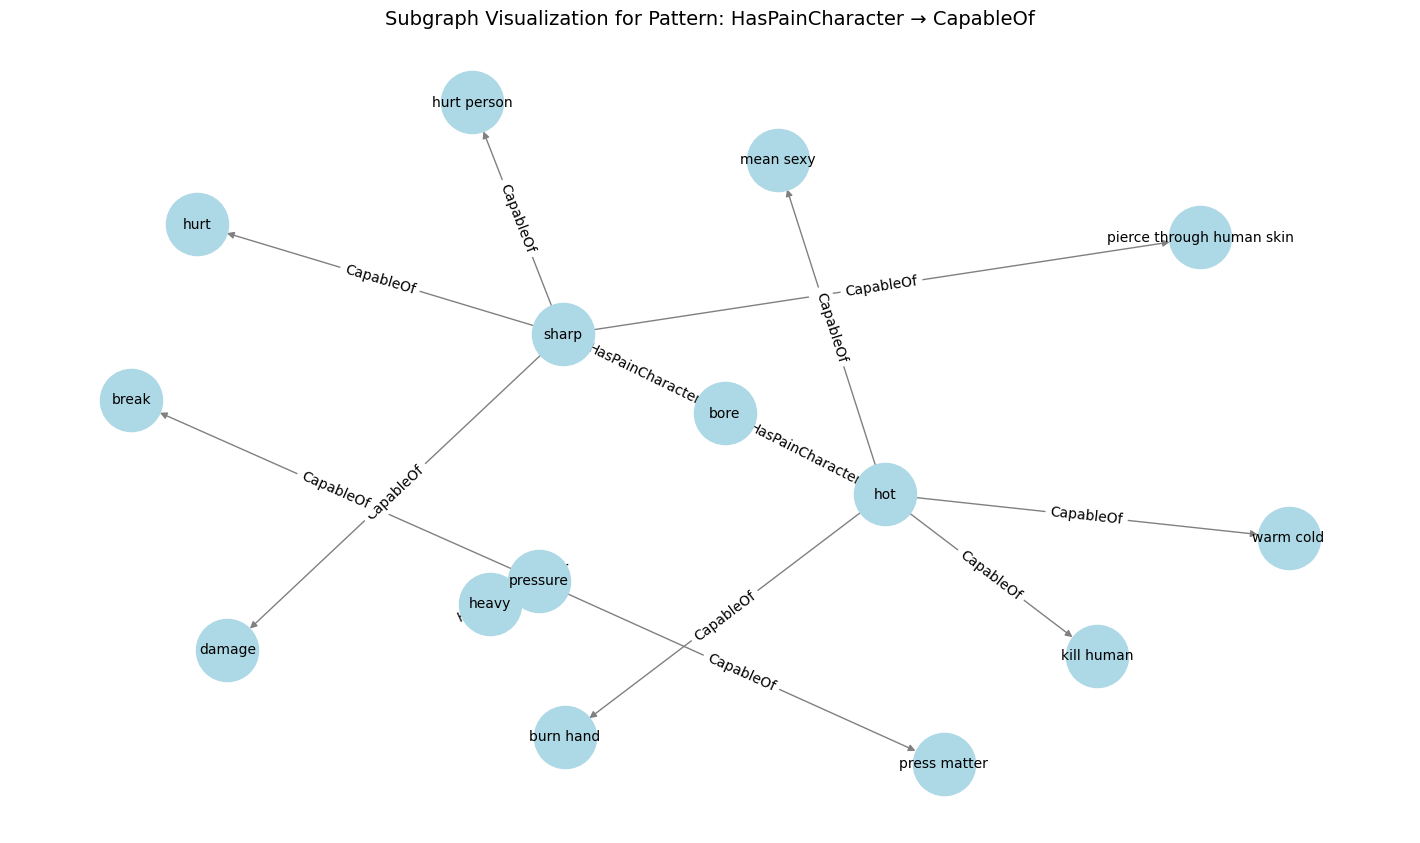

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'HasPainCharacter → CapableOf'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='HasPainCharacter')
    G_sub.add_edge(b, c, relation='CapableOf')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: HasPainCharacter → CapableOf

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'HasPainCharacter → CapableOf'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} HasPainCharacter {b}",
            "premise_2": f"{b} CapableOf {c}",
            "inferred": f"{a} CapableOf {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 50 rule candidates for pattern: HasPainCharacter → CapableOf


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_HasPainCharacter_CapableOf.csv", index=False)

print("Saved rule candidates to rule_candidates_HasPainCharacter_CapableOf.csv")


Saved rule candidates to rule_candidates_HasPainCharacter_CapableOf.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "HasPainCharacter → CapableOf"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_HasPainCharacter_CapableOf.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ⏲️ Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"📁 Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"📁 Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\n📊 Gemini Validation Summary:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Total Evaluated: {yes_count + no_count}")
print(f"📁 Saved to {results_file}")


✅ [1/50] Response: yes
✅ [2/50] Response: yes
✅ [3/50] Response: yes
✅ [4/50] Response: yes
✅ [5/50] Response: yes
✅ [6/50] Response: yes
✅ [7/50] Response: yes
✅ [8/50] Response: yes
✅ [9/50] Response: yes
✅ [10/50] Response: yes
✅ [11/50] Response: yes
✅ [12/50] Response: yes
✅ [13/50] Response: yes
✅ [14/50] Response: yes
✅ [15/50] Response: yes
✅ [16/50] Response: yes
✅ [17/50] Response: yes
✅ [18/50] Response: no
✅ [19/50] Response: yes
✅ [20/50] Response: yes
✅ [21/50] Response: yes
✅ [22/50] Response: yes
✅ [23/50] Response: yes
✅ [24/50] Response: yes
✅ [25/50] Response: yes
✅ [26/50] Response: yes
✅ [27/50] Response: yes
✅ [28/50] Response: yes
✅ [29/50] Response: no
✅ [30/50] Response: no
✅ [31/50] Response: no
✅ [32/50] Response: no
✅ [33/50] Response: yes
✅ [34/50] Response: yes
✅ [35/50] Response: yes
✅ [36/50] Response: yes
✅ [37/50] Response: yes
✅ [38/50] Response: yes
✅ [39/50] Response: yes
✅ [40/50] Response: yes
✅ [41/50] Response: yes
✅ [42/50] Response: yes
✅ [43/

**Visualize Gemini Response**

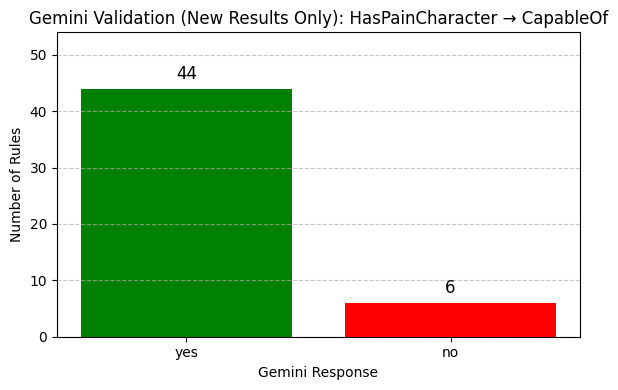

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): HasPainCharacter → CapableOf")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Appended 46 new 'yes' rules. Total now: 46


**Pattern: CreatedBy → InheritsFrom — 102 matches**

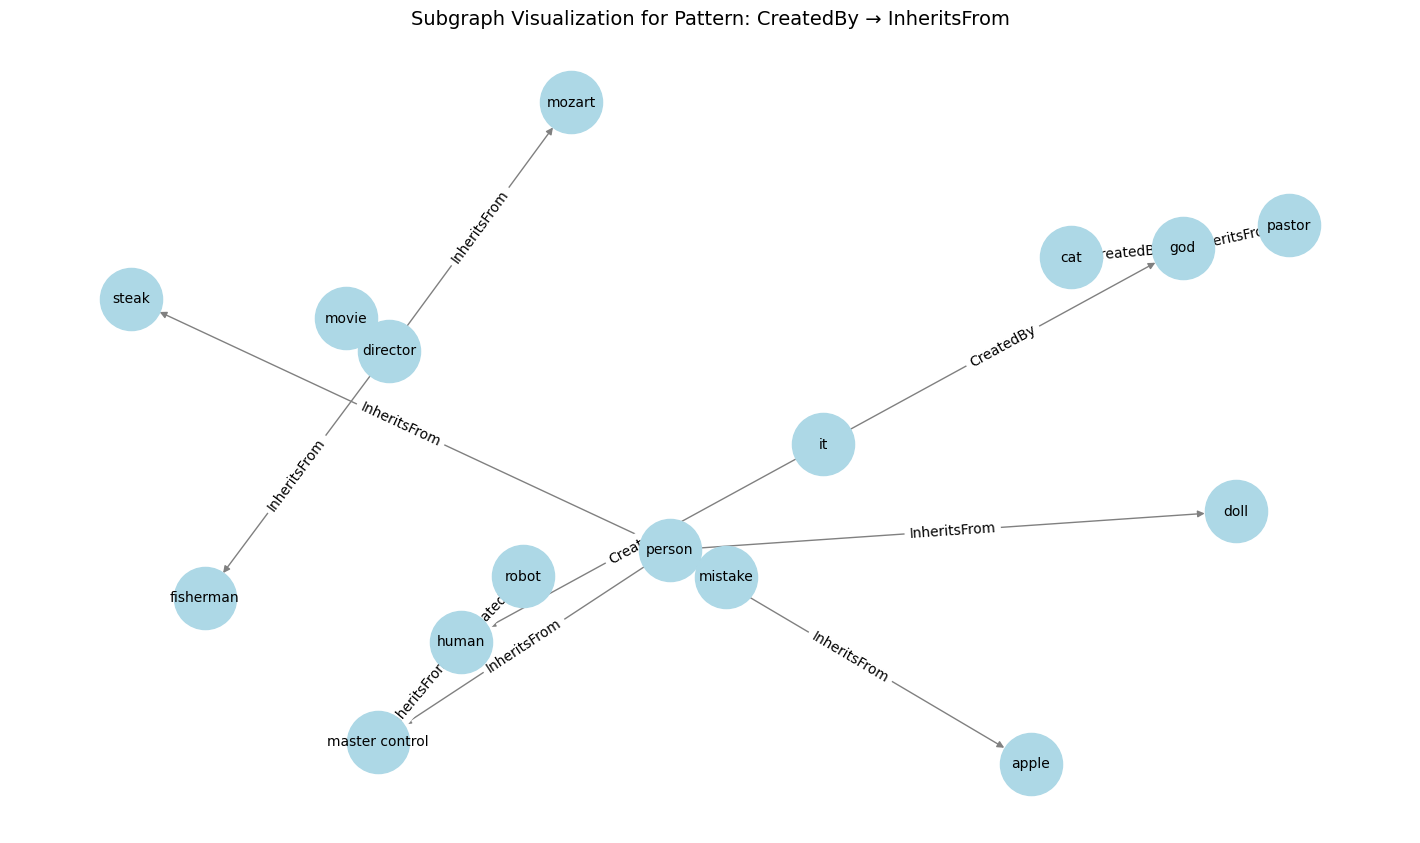

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'CreatedBy → InheritsFrom'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='CreatedBy')
    G_sub.add_edge(b, c, relation='InheritsFrom')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: CreatedBy → InheritsFrom

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'CreatedBy → InheritsFrom'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} CreatedBy {b}",
            "premise_2": f"{b} InheritsFrom {c}",
            "inferred": f"{a} InheritsFrom {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 102 rule candidates for pattern: CreatedBy → InheritsFrom


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_CreatedBy_InheritsFrom.csv", index=False)

print("Saved rule candidates to rule_candidates_CreatedBy_InheritsFrom.csv")


Saved rule candidates to rule_candidates_CreatedBy_InheritsFrom.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "CreatedBy → InheritsFrom"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_CreatedBy_InheritsFrom.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ⏲️ Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"📁 Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"📁 Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\n📊 Gemini Validation Summary:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Total Evaluated: {yes_count + no_count}")
print(f"📁 Saved to {results_file}")


✅ [1/102] Response: yes
✅ [2/102] Response: yes
✅ [3/102] Response: no
✅ [4/102] Response: no
✅ [5/102] Response: no
✅ [6/102] Response: yes
✅ [7/102] Response: no
✅ [8/102] Response: no
✅ [9/102] Response: no
✅ [10/102] Response: no
✅ [11/102] Response: no
✅ [12/102] Response: no
✅ [13/102] Response: yes
✅ [14/102] Response: no
✅ [15/102] Response: no
✅ [16/102] Response: yes
✅ [17/102] Response: no
✅ [18/102] Response: no
✅ [19/102] Response: no
✅ [20/102] Response: no
✅ [21/102] Response: yes
✅ [22/102] Response: no
✅ [23/102] Response: no
✅ [24/102] Response: no
✅ [25/102] Response: no
✅ [26/102] Response: no
✅ [27/102] Response: no
✅ [28/102] Response: no
✅ [29/102] Response: no
✅ [30/102] Response: no
✅ [31/102] Response: no
✅ [32/102] Response: no
✅ [33/102] Response: yes
✅ [34/102] Response: no
✅ [35/102] Response: no
✅ [36/102] Response: no
✅ [37/102] Response: no
✅ [38/102] Response: no
✅ [39/102] Response: no
✅ [40/102] Response: no
✅ [41/102] Response: no
✅ [42/102] Respons

**Visualize Gemini Response**

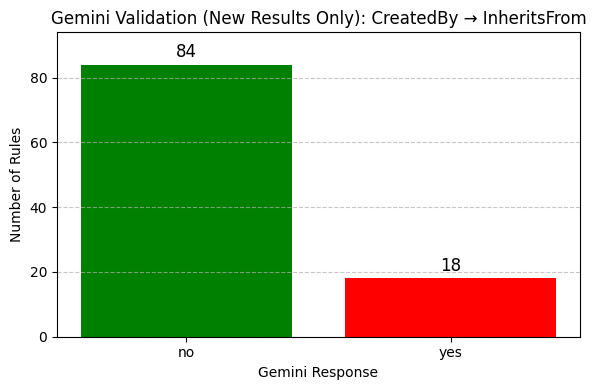

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): CreatedBy → InheritsFrom")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Appended 64 new 'yes' rules. Total now: 64


**Pattern: DefinedAs → MadeOf — 170 matches**

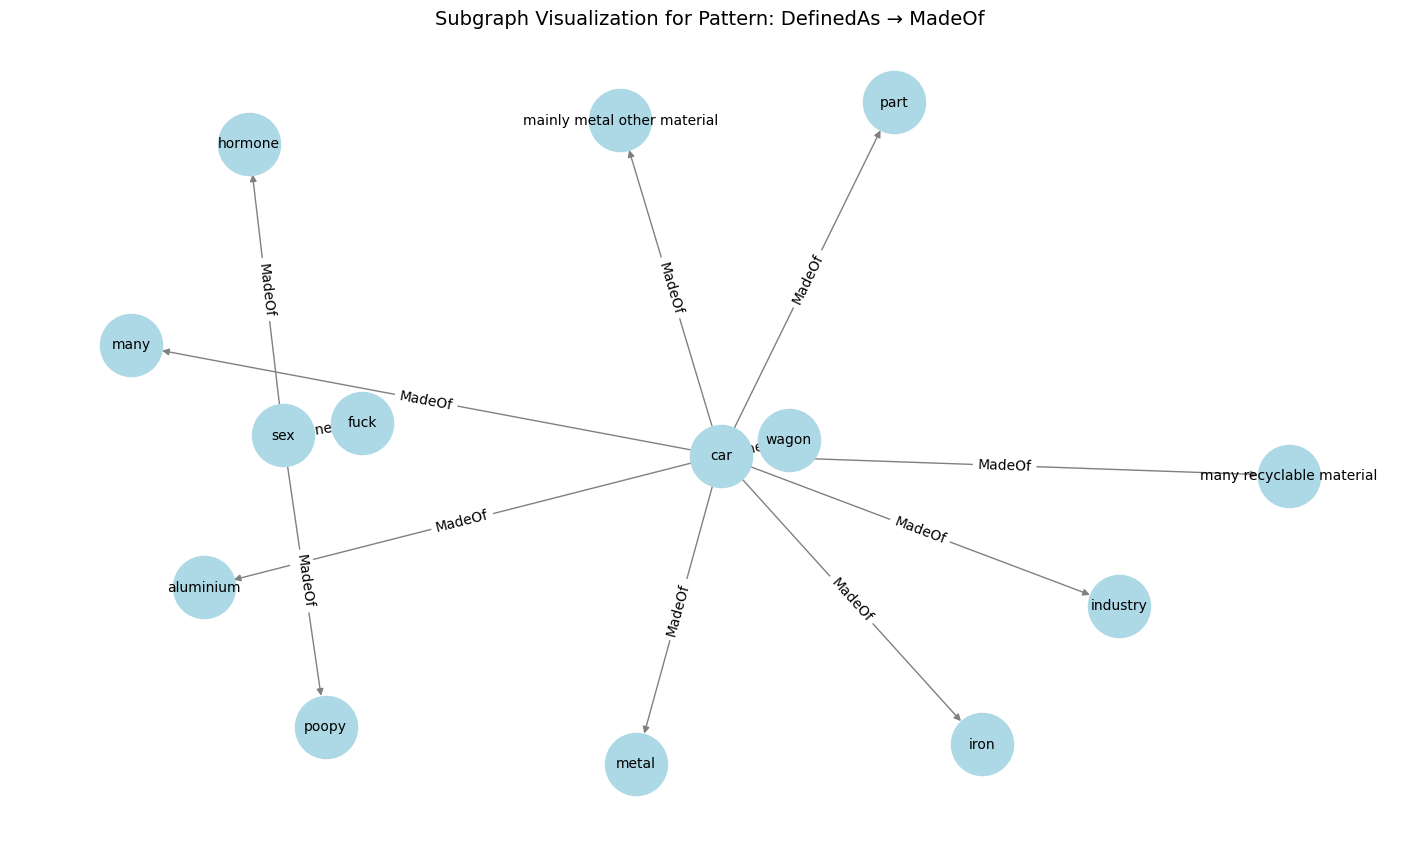

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'DefinedAs → MadeOf'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='DefinedAs')
    G_sub.add_edge(b, c, relation='MadeOf')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: DefinedAs → MadeOf

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'DefinedAs → MadeOf'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} DefinedAs {b}",
            "premise_2": f"{b} MadeOf {c}",
            "inferred": f"{a} MadeOf {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 170 rule candidates for pattern: DefinedAs → MadeOf


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_DefinedAs_MadeOf.csv", index=False)

print("Saved rule candidates to rule_candidates_DefinedAs_MadeOf.csv")


Saved rule candidates to rule_candidates_DefinedAs_MadeOf.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "DefinedAs → MadeOf"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_DefinedAs_MadeOf.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ⏲️ Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"📁 Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"📁 Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\n📊 Gemini Validation Summary:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Total Evaluated: {yes_count + no_count}")
print(f"📁 Saved to {results_file}")


✅ [1/170] Response: yes
✅ [2/170] Response: yes
✅ [3/170] Response: yes
✅ [4/170] Response: yes
✅ [5/170] Response: yes
✅ [6/170] Response: yes
✅ [7/170] Response: yes
✅ [8/170] Response: yes
✅ [9/170] Response: yes
✅ [10/170] Response: yes
✅ [11/170] Response: yes
✅ [12/170] Response: yes
✅ [13/170] Response: yes
✅ [14/170] Response: yes
✅ [15/170] Response: yes
✅ [16/170] Response: yes
✅ [17/170] Response: yes
✅ [18/170] Response: yes
✅ [19/170] Response: yes
✅ [20/170] Response: yes
✅ [21/170] Response: yes
✅ [22/170] Response: yes
✅ [23/170] Response: yes
✅ [24/170] Response: yes
✅ [25/170] Response: yes
✅ [26/170] Response: no
✅ [27/170] Response: no
✅ [28/170] Response: no
✅ [29/170] Response: yes
✅ [30/170] Response: yes
✅ [31/170] Response: yes
✅ [32/170] Response: yes
✅ [33/170] Response: yes
✅ [34/170] Response: yes
✅ [35/170] Response: no
✅ [36/170] Response: yes
✅ [37/170] Response: yes
✅ [38/170] Response: yes
✅ [39/170] Response: yes
✅ [40/170] Response: yes
✅ [41/170] Re

**Visualize Gemini Response**

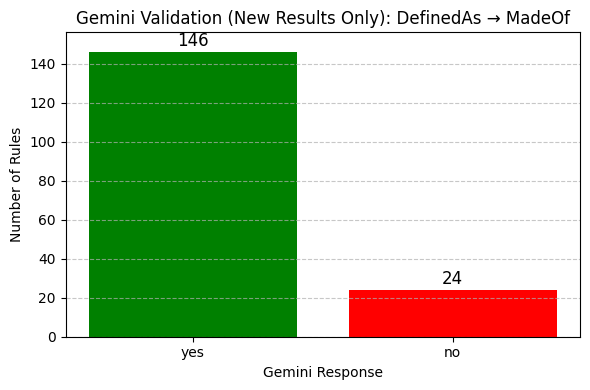

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): DefinedAs → MadeOf")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Appended 210 new 'yes' rules. Total now: 210


**Pattern: InstanceOf → AtLocation — 530 matches**

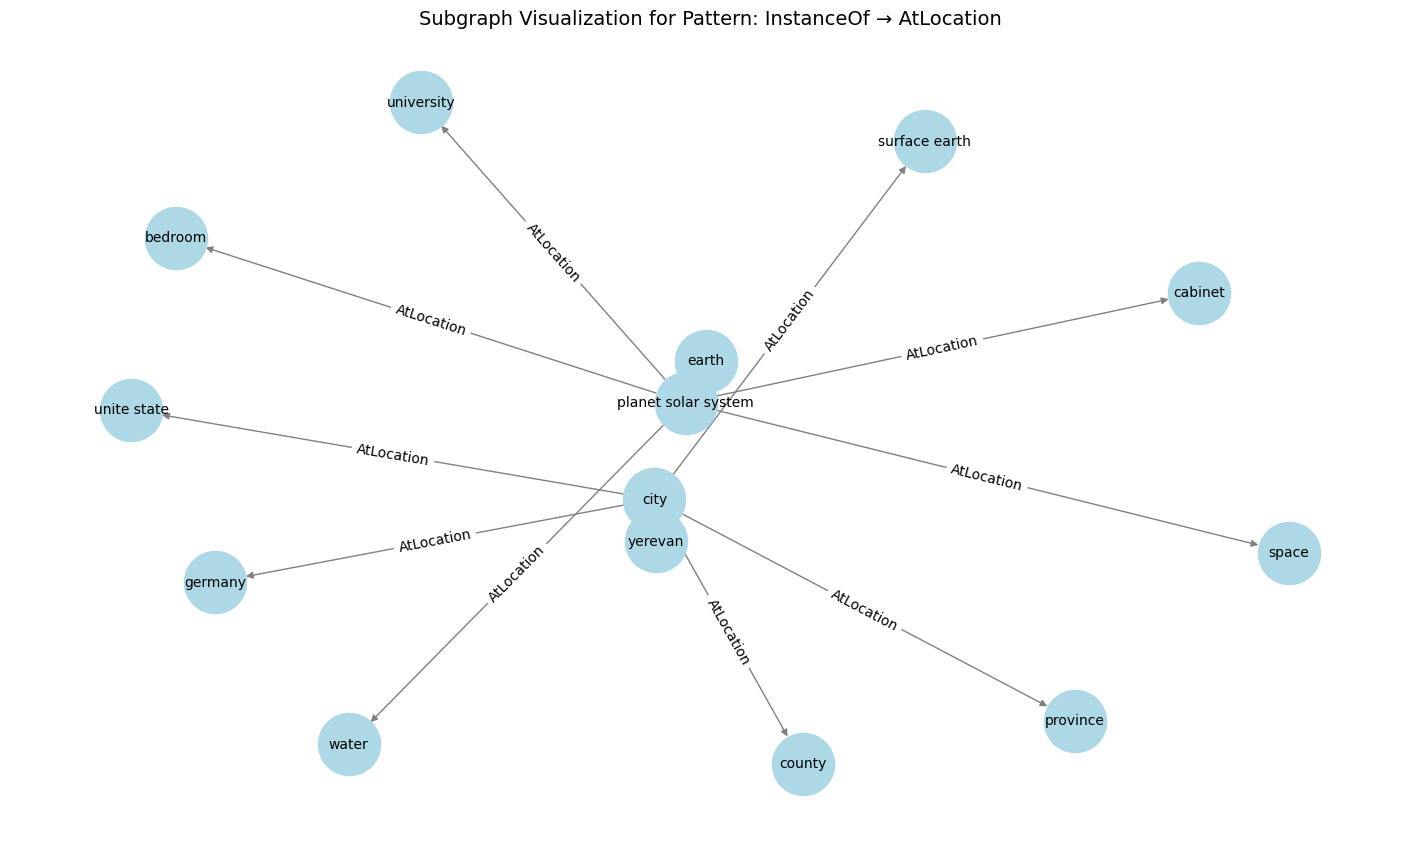

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'InstanceOf → AtLocation'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='InstanceOf')
    G_sub.add_edge(b, c, relation='AtLocation')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: InstanceOf → AtLocation

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'InstanceOf → AtLocation'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} InstanceOf {b}",
            "premise_2": f"{b} AtLocation {c}",
            "inferred": f"{a} AtLocation {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 530 rule candidates for pattern: InstanceOf → AtLocation


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_InstanceOf_AtLocation.csv", index=False)

print("Saved rule candidates to rule_candidates_InstanceOf_AtLocation.csv")


Saved rule candidates to rule_candidates_InstanceOf_AtLocation.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "InstanceOf_AtLocation"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_InstanceOf_AtLocation.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ⏲️ Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"📁 Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"📁 Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\n📊 Gemini Validation Summary:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Total Evaluated: {yes_count + no_count}")
print(f"📁 Saved to {results_file}")


✅ [1/530] Response: no
✅ [2/530] Response: no
✅ [3/530] Response: no
✅ [4/530] Response: no
✅ [5/530] Response: yes
✅ [6/530] Response: no
✅ [7/530] Response: yes
✅ [8/530] Response: no
✅ [9/530] Response: yes
✅ [10/530] Response: no
✅ [11/530] Response: no
✅ [12/530] Response: no
✅ [13/530] Response: no
✅ [14/530] Response: no
✅ [15/530] Response: no
✅ [16/530] Response: no
✅ [17/530] Response: yes
✅ [18/530] Response: yes
✅ [19/530] Response: no
✅ [20/530] Response: no
✅ [21/530] Response: no
✅ [22/530] Response: no
✅ [23/530] Response: no
✅ [24/530] Response: no
✅ [25/530] Response: no
✅ [26/530] Response: yes
✅ [27/530] Response: no
✅ [28/530] Response: yes
✅ [29/530] Response: yes
✅ [30/530] Response: yes
✅ [31/530] Response: yes
✅ [32/530] Response: yes
✅ [33/530] Response: no
✅ [34/530] Response: no
✅ [35/530] Response: no
✅ [36/530] Response: yes
✅ [37/530] Response: no
✅ [38/530] Response: yes
✅ [39/530] Response: yes
✅ [40/530] Response: yes
✅ [41/530] Response: yes
✅ [42/530

**Visualize Gemini Response**

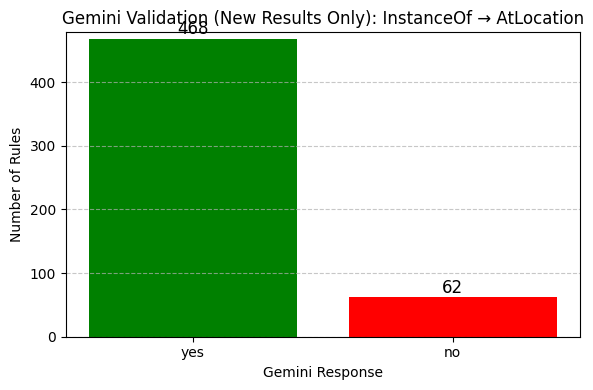

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): InstanceOf → AtLocation")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Appended 678 new 'yes' rules. Total now: 678


**Pattern: PartOf → HasSubevent — 1607 matches**

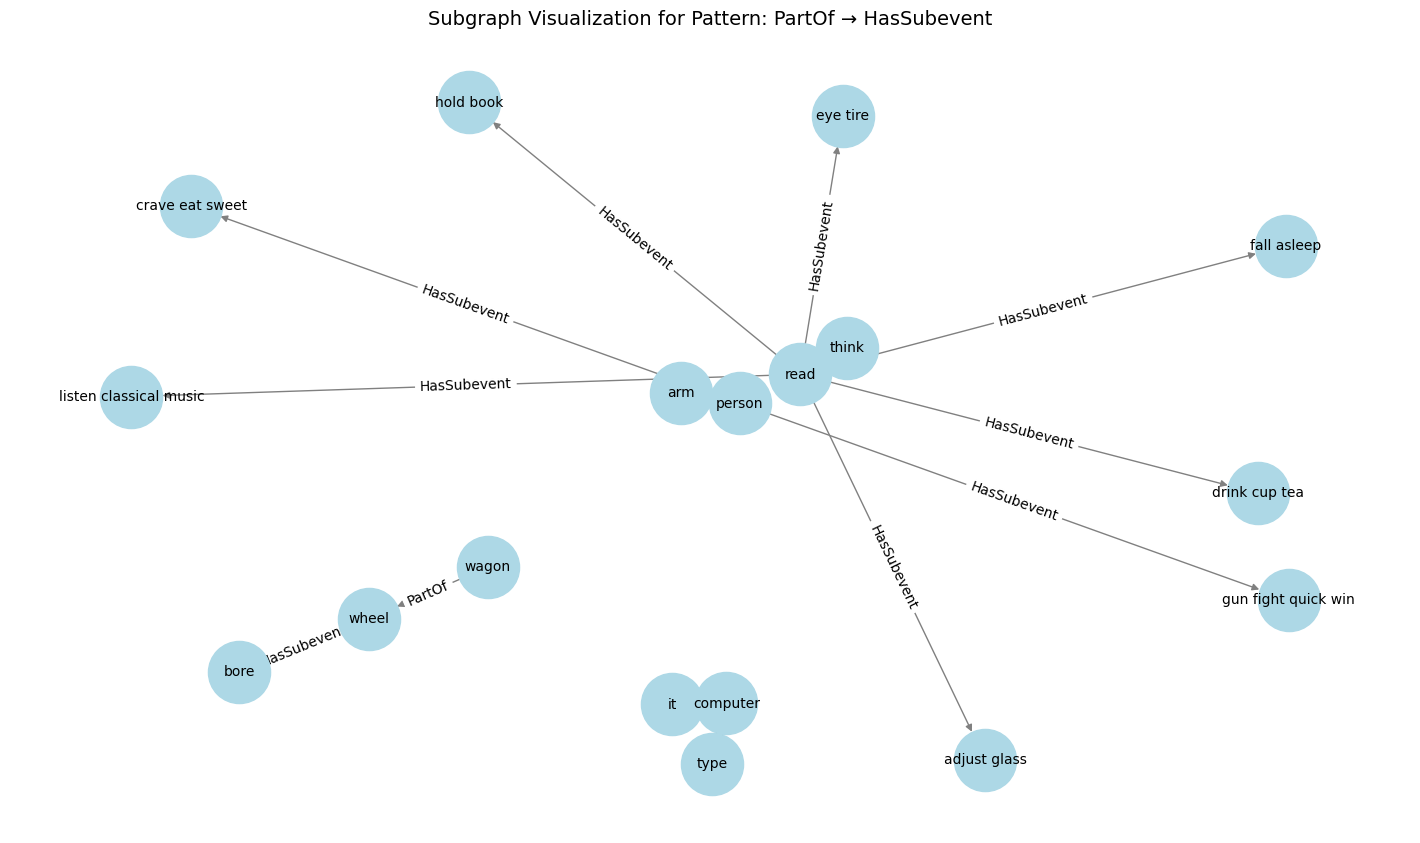

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'PartOf → HasSubevent'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='PartOf')
    G_sub.add_edge(b, c, relation='HasSubevent')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: PartOf → HasSubevent

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'PartOf → HasSubevent'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} PartOf {b}",
            "premise_2": f"{b} HasSubevent {c}",
            "inferred": f"{a} HasSubevent {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 1607 rule candidates for pattern: PartOf → HasSubevent


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_PartOf_HasSubevent.csv", index=False)

print("Saved rule candidates to rule_candidates_PartOf_HasSubevent.csv")


Saved rule candidates to rule_candidates_PartOf_HasSubevent.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "PartOf_HasSubevent"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_PartOf_HasSubevent.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ⏲️ Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"📁 Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"📁 Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\n📊 Gemini Validation Summary:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Total Evaluated: {yes_count + no_count}")
print(f"📁 Saved to {results_file}")


✅ [1/1607] Response: no
✅ [2/1607] Response: no
✅ [3/1607] Response: no
✅ [4/1607] Response: yes
✅ [5/1607] Response: no
✅ [6/1607] Response: no
✅ [7/1607] Response: no
✅ [8/1607] Response: no
✅ [9/1607] Response: no
✅ [10/1607] Response: no
✅ [11/1607] Response: no
✅ [12/1607] Response: no
✅ [13/1607] Response: no
✅ [14/1607] Response: no
✅ [15/1607] Response: yes
✅ [16/1607] Response: no
✅ [17/1607] Response: no
✅ [18/1607] Response: yes
✅ [19/1607] Response: yes
✅ [20/1607] Response: no
✅ [21/1607] Response: yes
✅ [22/1607] Response: yes
✅ [23/1607] Response: no
✅ [24/1607] Response: no
✅ [25/1607] Response: no
✅ [26/1607] Response: no
✅ [27/1607] Response: no
✅ [28/1607] Response: no
✅ [29/1607] Response: no
✅ [30/1607] Response: no
✅ [31/1607] Response: no
✅ [32/1607] Response: no
✅ [33/1607] Response: no
✅ [34/1607] Response: no
✅ [35/1607] Response: no
✅ [36/1607] Response: no
✅ [37/1607] Response: no
✅ [38/1607] Response: no
✅ [39/1607] Response: yes
✅ [40/1607] Response: no
✅ 

ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 229.11ms


✅ [347/1607] Response: no
✅ [348/1607] Response: no
✅ [349/1607] Response: no
✅ [350/1607] Response: no
✅ [351/1607] Response: no
✅ [352/1607] Response: no
✅ [353/1607] Response: no
✅ [354/1607] Response: no
✅ [355/1607] Response: no
✅ [356/1607] Response: no
✅ [357/1607] Response: no
✅ [358/1607] Response: no
✅ [359/1607] Response: no
✅ [360/1607] Response: no
✅ [361/1607] Response: no
✅ [362/1607] Response: no
✅ [363/1607] Response: no
✅ [364/1607] Response: no
✅ [365/1607] Response: no
✅ [366/1607] Response: no
✅ [367/1607] Response: no
✅ [368/1607] Response: no
✅ [369/1607] Response: no
✅ [370/1607] Response: no
✅ [371/1607] Response: no
✅ [372/1607] Response: no
✅ [373/1607] Response: no
✅ [374/1607] Response: no
✅ [375/1607] Response: no
✅ [376/1607] Response: no
✅ [377/1607] Response: no
✅ [378/1607] Response: no
✅ [379/1607] Response: no
✅ [380/1607] Response: no
✅ [381/1607] Response: no
✅ [382/1607] Response: no
✅ [383/1607] Response: no
✅ [384/1607] Response: no
✅ [385/1607]

**Visualize Gemini Response**

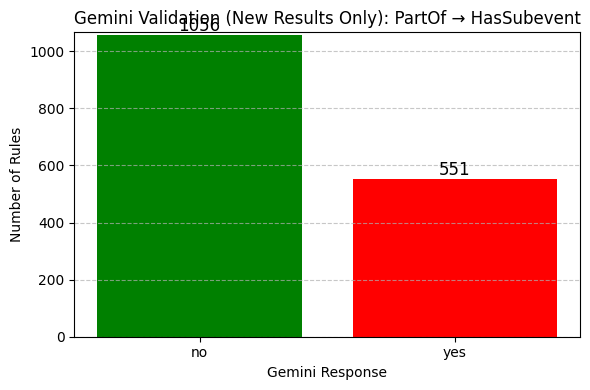

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): PartOf → HasSubevent")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Appended 1229 new 'yes' rules. Total now: 1229


**Pattern: LocatedNear → Causes — 3084 matches**

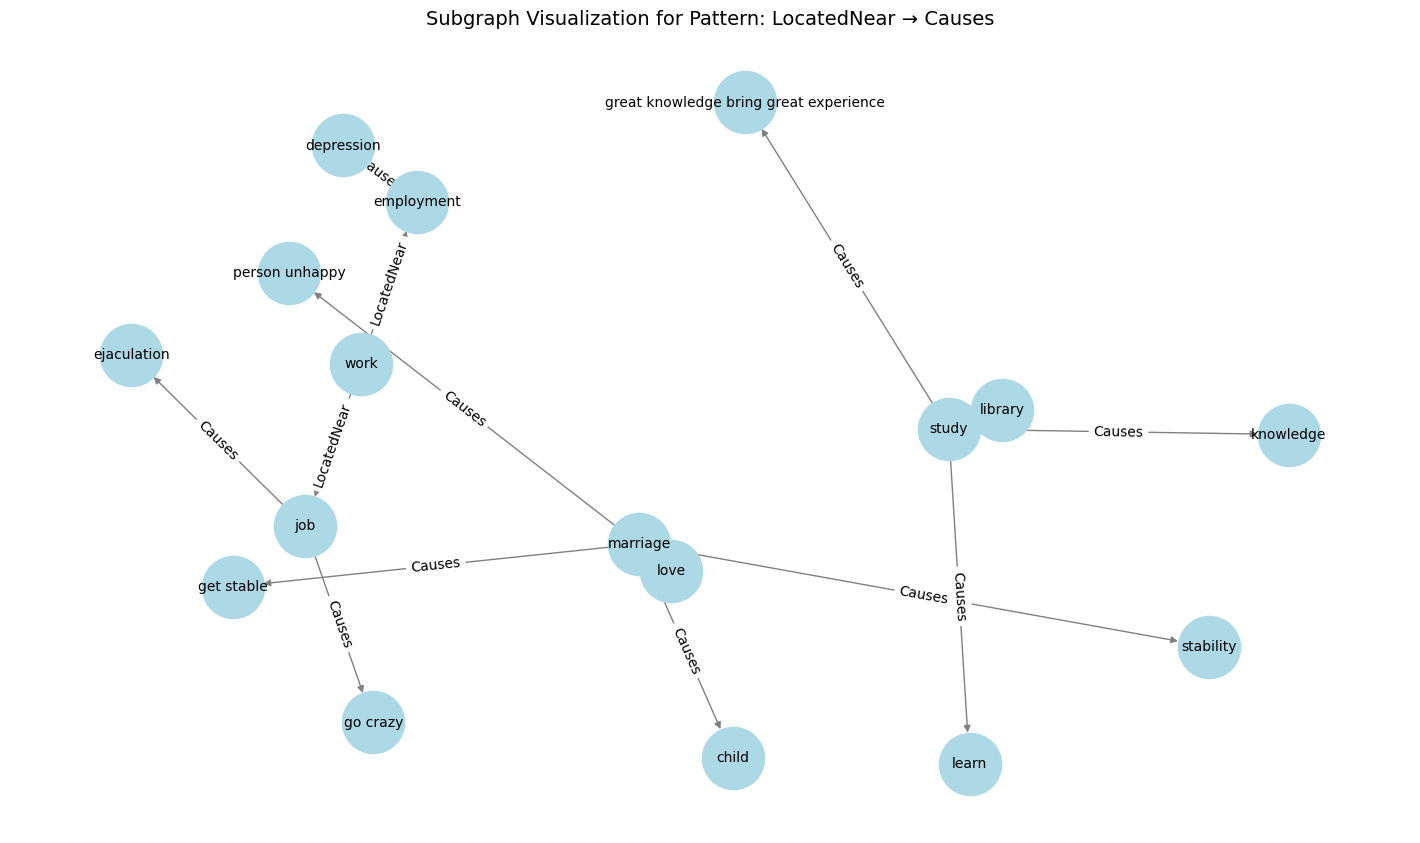

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'LocatedNear → Causes'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='LocatedNear')
    G_sub.add_edge(b, c, relation='Causes')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: LocatedNear → Causes

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'LocatedNear → Causes'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} LocatedNear {b}",
            "premise_2": f"{b} Causes {c}",
            "inferred": f"{a} Causes {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 3084 rule candidates for pattern: LocatedNear → Causes


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_LocatedNear_Causes.csv", index=False)

print("Saved rule candidates to rule_candidates_LocatedNear_Causes.csv")


Saved rule candidates to rule_candidates_LocatedNear_Causes.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation with Appending and Stats

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # Set manually in Colab > Secrets
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name (used for tagging rows)
pattern_name = "LocatedNear_Causes"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_LocatedNear_Causes.csv").to_dict(orient="records")

# 4. Initialize Gemini Flash
model = genai.GenerativeModel("gemini-2.0-flash")

# 5. Evaluate with Gemini
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)  # ⏲️ Adjust as needed to avoid quota errors

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 6. Save results safely (append if file exists)
results_df = pd.DataFrame(llm_evals)
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"

if os.path.exists(results_file):
    previous_df = pd.read_csv(results_file)
    combined_df = pd.concat([previous_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"📁 Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"📁 Created new file: {results_file} with {len(results_df)} rows")

# 7. Stats
print("\n📊 Gemini Validation Summary:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Total Evaluated: {yes_count + no_count}")
print(f"📁 Saved to {results_file}")


✅ [1/3084] Response: yes
✅ [2/3084] Response: no
✅ [3/3084] Response: yes
✅ [4/3084] Response: no
✅ [5/3084] Response: no
✅ [6/3084] Response: no
✅ [7/3084] Response: no
✅ [8/3084] Response: no
✅ [9/3084] Response: no
✅ [10/3084] Response: no
✅ [11/3084] Response: no
✅ [12/3084] Response: no
✅ [13/3084] Response: no
✅ [14/3084] Response: no
✅ [15/3084] Response: no
✅ [16/3084] Response: no
✅ [17/3084] Response: no
✅ [18/3084] Response: no
✅ [19/3084] Response: no
✅ [20/3084] Response: no
✅ [21/3084] Response: no
✅ [22/3084] Response: no
✅ [23/3084] Response: no
✅ [24/3084] Response: yes
✅ [25/3084] Response: no
✅ [26/3084] Response: no
✅ [27/3084] Response: no
✅ [28/3084] Response: no
✅ [29/3084] Response: no
✅ [30/3084] Response: no
✅ [31/3084] Response: no
✅ [32/3084] Response: no
✅ [33/3084] Response: no
✅ [34/3084] Response: no
✅ [35/3084] Response: no
✅ [36/3084] Response: no
✅ [37/3084] Response: no
✅ [38/3084] Response: yes
✅ [39/3084] Response: yes
✅ [40/3084] Response: no
✅ [4

**Visualize Gemini Response**

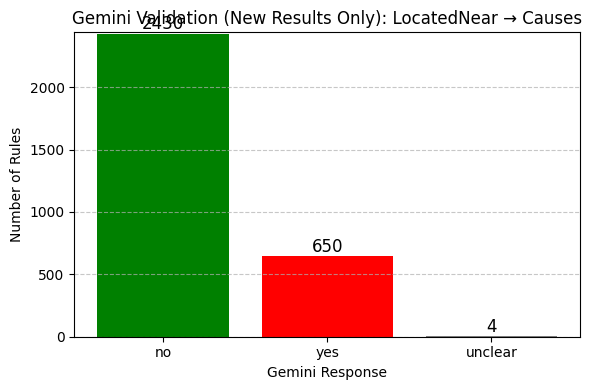

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): LocatedNear → Causes")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "/content/drive/MyDrive/gemini_outputs/gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Appended 1879 new 'yes' rules. Total now: 1879


**Pattern: InheritsFrom → AtLocation — 10114 matches**

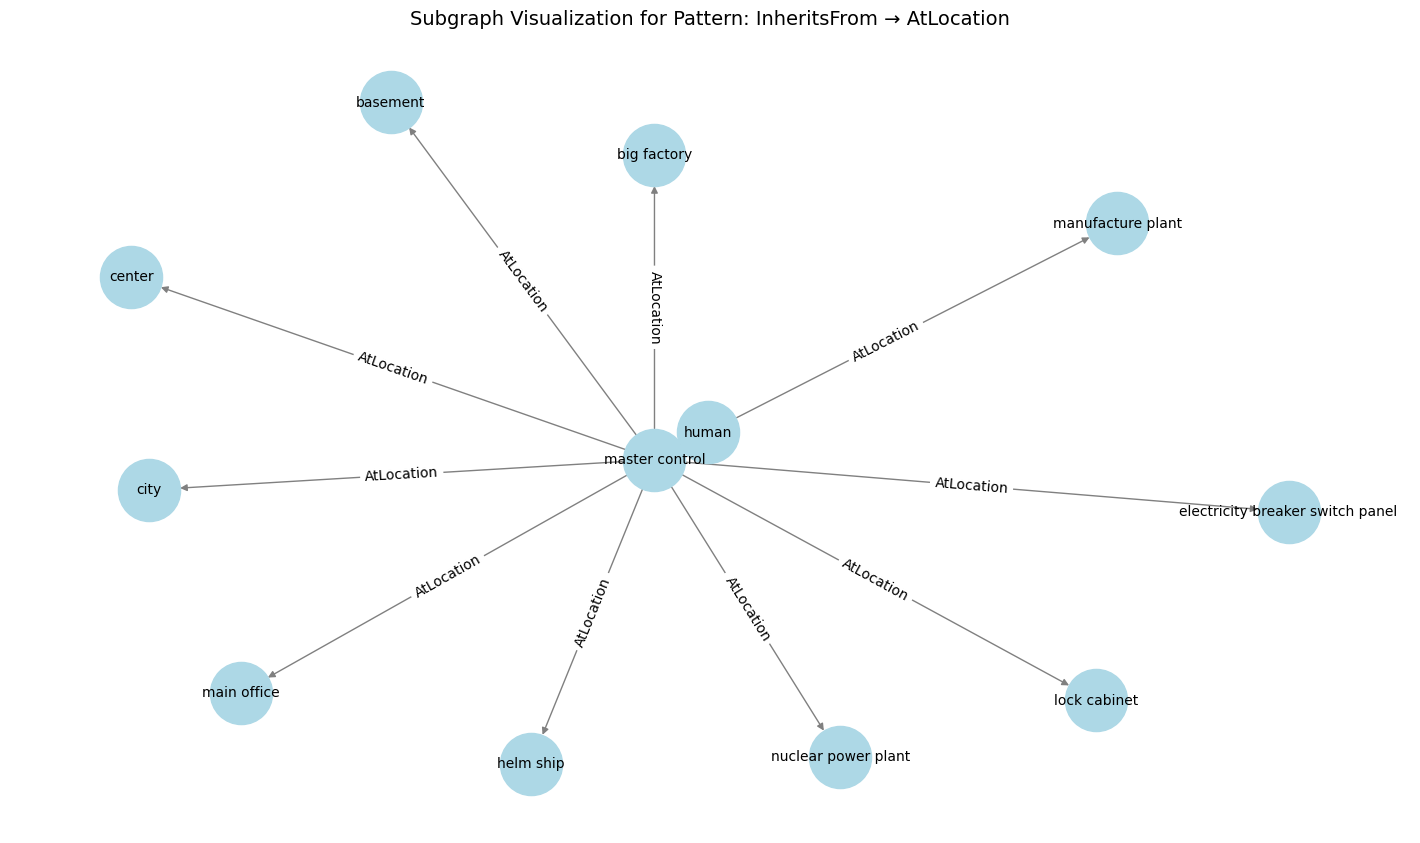

In [ ]:
import matplotlib.pyplot as plt

# Select a pattern to visualize
pattern_name = 'InheritsFrom → AtLocation'

# Take the first N samples to visualize (clean ones only)
examples = two_hop_patterns[pattern_name][:10]  # you can change 10 to any number

# Create subgraph
G_sub = nx.DiGraph()

for a, b, c in examples:
    G_sub.add_edge(a, b, relation='InheritsFrom')
    G_sub.add_edge(b, c, relation='AtLocation')

# Draw the subgraph
plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_sub, seed=42)

# Draw nodes and edges
nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(
    G_sub,
    pos,
    edge_labels={(u, v): d['relation'] for u, v, d in G_sub.edges(data=True)},
    font_color='black'
)

plt.title(f"Subgraph Visualization for Pattern: {pattern_name}", fontsize=14)
plt.axis('off')
plt.show()


**Build rule_candidates from two_hop_patterns**

We'll extract symbolic rules from the pattern I discovered: InheritsFrom → AtLocation

In [ ]:
# Ensure this matches your discovered pattern
target_pattern = 'InheritsFrom → AtLocation'

# Extract samples from that pattern
rule_candidates = []

if target_pattern in two_hop_patterns:
    samples = two_hop_patterns[target_pattern]  # Use more if desired

    for a, b, c in samples:
        rule = {
            "premise_1": f"{a} InheritsFrom {b}",
            "premise_2": f"{b} AtLocation {c}",
            "inferred": f"{a} AtLocation {c}",
            "support_count": 1  # optional
        }
        rule_candidates.append(rule)

    print(f"✅ Created {len(rule_candidates)} rule candidates for pattern: {target_pattern}")
else:
    print(f"❌ Pattern '{target_pattern}' not found in two_hop_patterns.")


✅ Created 10114 rule candidates for pattern: InheritsFrom → AtLocation


**Save the rule candidates in csv file**

In [ ]:
import pandas as pd

# Convert to DataFrame
rules_df = pd.DataFrame(rule_candidates)

# Save to CSV
rules_df.to_csv("rule_candidates_InheritsFrom_AtLocation.csv", index=False)

print("Saved rule candidates to rule_candidates_InheritsFrom_AtLocation.csv")


Saved rule candidates to rule_candidates_InheritsFrom_AtLocation.csv


**Gemini Evaluation Code**

In [ ]:
# STEP: Gemini 2.0 Integration for Rule Validation (Resumable + Stats)

!pip install -q --upgrade google-generativeai

import pandas as pd
import google.generativeai as genai
from google.colab import drive, userdata
import time
import os

# 1. Configure Gemini
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

# 2. Pattern name
pattern_name = "InheritsFrom_AtLocation"

# 3. Load rule candidates
rule_candidates = pd.read_csv("/content/rule_candidates_InheritsFrom_AtLocation.csv").to_dict(orient="records")

# 4. Load previously evaluated results
results_file = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"
evaluated_inferred = set()

if os.path.exists(results_file):
    existing_df = pd.read_csv(results_file)
    evaluated_inferred = set(existing_df["Inferred"].tolist())  # Use Inferred to avoid rechecking
    print(f"🔁 Loaded {len(evaluated_inferred)} previously evaluated rules")

# 5. Initialize Gemini
model = genai.GenerativeModel("gemini-2.0-flash")

# 6. Run LLM evaluation
llm_evals = []
yes_count = 0
no_count = 0

for idx, rule in enumerate(rule_candidates):
    #if rule["inferred"] in evaluated_inferred:
        #continue  # Skip already evaluated rules

    try:
        prompt = (
            f"{rule['premise_1']}, and {rule['premise_2']}.\n"
            f"Based on these facts, can we conclude that {rule['inferred']}?\n"
            f"Answer yes or no."
        )

        response = model.generate_content(prompt)
        answer_text = response.text.strip().split("\n")[0].lower()

        if answer_text.startswith("yes"):
            decision = "yes"
            yes_count += 1
        elif answer_text.startswith("no"):
            decision = "no"
            no_count += 1
        else:
            decision = "unclear"

        llm_evals.append({
            "Pattern": pattern_name,
            "Premise 1": rule["premise_1"],
            "Premise 2": rule["premise_2"],
            "Inferred": rule["inferred"],
            "Gemini Response": decision
        })

        print(f"✅ [{idx+1}/{len(rule_candidates)}] Response: {decision}")
        time.sleep(2)

    except Exception as e:
        print(f"❌ Skipped rule {idx+1} due to error: {e}")
        time.sleep(10)

# 7. Append or create CSV file
results_df = pd.DataFrame(llm_evals)

if os.path.exists(results_file):
    combined_df = pd.concat([existing_df, results_df], ignore_index=True)
    combined_df.drop_duplicates(subset=["Inferred"], inplace=True)
    combined_df.to_csv(results_file, index=False)
    print(f"📁 Appended results. Total rows: {len(combined_df)}")
else:
    results_df.to_csv(results_file, index=False)
    print(f"📁 Created new file: {results_file} with {len(results_df)} rows")

# 8. Stats
print("\n📊 Gemini Validation Summary:")
print(f"✔️ YES: {yes_count}")
print(f"❌ NO : {no_count}")
print(f"🔢 Newly Evaluated This Run: {yes_count + no_count}")
print(f"📁 Saved to {results_file}")


Streaming output truncated to the last 5000 lines.
✅ [5122/10114] Response: yes
✅ [5123/10114] Response: yes
✅ [5124/10114] Response: yes
✅ [5125/10114] Response: yes
✅ [5126/10114] Response: yes
✅ [5127/10114] Response: yes
✅ [5128/10114] Response: yes
✅ [5129/10114] Response: yes
✅ [5130/10114] Response: yes
✅ [5131/10114] Response: yes
✅ [5132/10114] Response: yes
✅ [5133/10114] Response: yes
✅ [5134/10114] Response: yes
✅ [5135/10114] Response: yes
✅ [5136/10114] Response: yes
✅ [5137/10114] Response: yes
✅ [5138/10114] Response: no
✅ [5139/10114] Response: yes
✅ [5140/10114] Response: yes
✅ [5141/10114] Response: yes
✅ [5142/10114] Response: no
✅ [5143/10114] Response: yes
✅ [5144/10114] Response: yes
✅ [5145/10114] Response: yes
✅ [5146/10114] Response: no
✅ [5147/10114] Response: yes
✅ [5148/10114] Response: yes
✅ [5149/10114] Response: no
✅ [5150/10114] Response: yes
✅ [5151/10114] Response: yes
✅ [5152/10114] Response: no
✅ [5153/10114] Response: no
✅ [5154/10114] Response: ye

**Visualize Gemini Response**

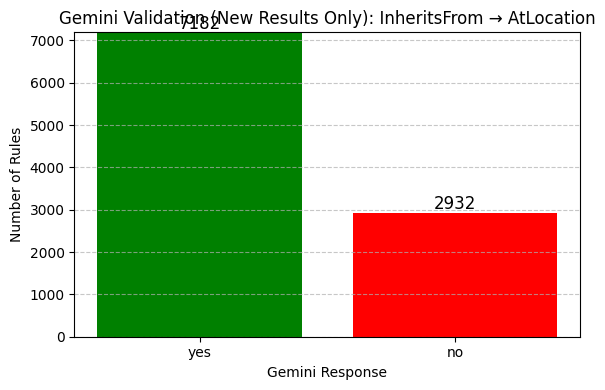

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load ONLY the new results just created in the current session
results_df = pd.DataFrame(llm_evals)  # this assumes you're continuing from the evaluation script

# Count occurrences of Gemini response in the current session
counts = results_df["Gemini Response"].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["green", "red", "gray"])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title("Gemini Validation (New Results Only): InheritsFrom → AtLocation")
plt.xlabel("Gemini Response")
plt.ylabel("Number of Rules")
plt.ylim(0, max(counts.values) + 10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Save All 'Yes' Inferred Rules**

In [ ]:
import pandas as pd
import os

# Load the evaluated results
df = pd.read_csv("/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv")

# Filter only the rows where Gemini said "yes"
yes_df = df[df["Gemini Response"].str.lower().str.strip() == "yes"]

# Path to the master CSV file for all valid rules
output_path = "gemini_confirmed_yes_rules.csv"

# If the file already exists, append new "yes" rules (avoid duplicates)
if os.path.exists(output_path):
    existing = pd.read_csv(output_path)
    combined = pd.concat([existing, yes_df], ignore_index=True).drop_duplicates()
    combined.to_csv(output_path, index=False)
    print(f"✅ Appended {len(yes_df)} new 'yes' rules. Total now: {len(combined)}")
else:
    yes_df.to_csv(output_path, index=False)
    print(f"✅ Saved first {len(yes_df)} 'yes' rules to {output_path}")


✅ Saved first 8923 'yes' rules to gemini_confirmed_yes_rules.csv


In [ ]:
import pandas as pd

# Load the CSV file
csv_path = "/content/drive/MyDrive/gemini_outputs/gemini_evaluated_rules.csv"
df = pd.read_csv(csv_path)

# Drop duplicates based on the 'Inferred' column
df.drop_duplicates(subset=["Inferred"], inplace=True)

# Save the cleaned DataFrame back to the same file
df.to_csv(csv_path, index=False)

print(f"✅ Cleaned file saved. Total unique rules: {len(df)}")
